<a href="https://colab.research.google.com/github/weiling0325/Schizophrenia-Detection-Using-Microbiome-Data/blob/main/Approach_1_PyImpetus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install PyImpetus

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import math
import numpy as np
import pandas as pd
from collections import Counter
from PyImpetus import PPIMBC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
import time
import pickle

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/training_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/testing_data.csv')

In [5]:
X_train = train_df.drop(columns=['diagnosis'])
y_train = train_df['diagnosis']

X_test = test_df.drop(columns=['diagnosis'])
y_test = test_df['diagnosis']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 354 out of 354 | elapsed: 28.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s fin

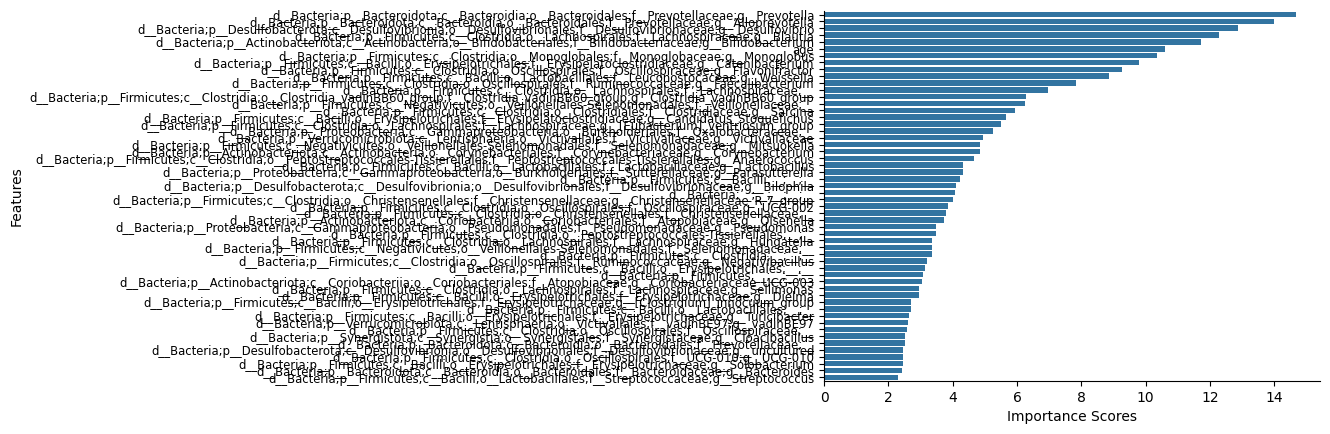

Number of features selected: 54
Markov Blanket: ['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella', 'd__Bacteria;p__Desulfobacterota;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium', 'age', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__Monoglobus', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Flavonifractor', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella', 'd__Bacteria;p__Firmicutes;c__Clost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the PPIMBC model for feature selection using the random forest classifier as the base model
model = PPIMBC(rf, p_val_thresh=0.1, num_simul=30, simul_size=0.2, simul_type=0, sig_test_type="non-parametric", cv=0, verbose=2, random_state=42)

# Fit the PPIMBC model on the training data and transform the train dataset to the selected feature subset
X_train_selected = model.fit_transform(X_train, y_train)

# Transform the test dataset with the selected features
X_test_selected = model.transform(X_test)

# Plot the feature importance scores
model.feature_importance()

# Get the column names of the selected features
selected_features = model.MB

# Check if 'age' is one of the selected features, if not add it
if 'age' not in selected_features:
    print(f"'age' not in selected features, adding 'age'.")
    selected_features.append('age')

print("Number of features selected:", len(selected_features))
print("Markov Blanket:", selected_features)
print("Feature importance Scores:", model.feat_imp_scores)

# Create a new DataFrame with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train RandomForestClassifier on the selected features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test_selected)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy using selected PPIMBC features: {accuracy:.4f}")

In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores (5-fold): {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")


Cross-validation accuracy scores (5-fold): [0.7826087  0.82608696 1.         0.81818182 0.77272727]
Mean cross-validation accuracy: 0.8399


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        24
           1       0.90      0.72      0.80        25

    accuracy                           0.82        49
   macro avg       0.83      0.82      0.82        49
weighted avg       0.83      0.82      0.81        49


Confusion Matrix:
[[22  2]
 [ 7 18]]



AUC-ROC Score: 0.8267


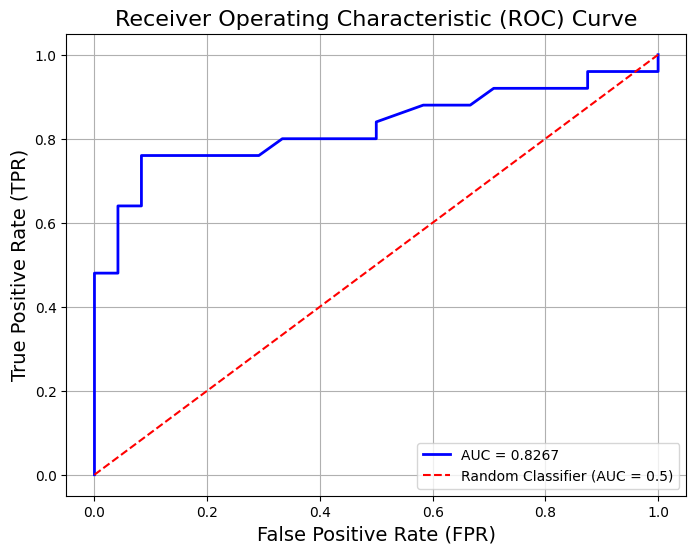

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = rf_model.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Perform the hyperparameters tuning for RandomForestclassifier using RandomizedSearchCV
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)

# Fit the GridSearchCV object to the selected feature subset
rf_random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters for RandomForestClassifier
best_rf_params = rf_random_search.best_params_
print(f"Best RandomForest hyperparameters: {best_rf_params}")

# Get the best RandomForest model
best_rf_model = rf_random_search.best_estimator_

# Train RandomForestClassifier on the selected features with the best hyperparameters
best_rf_model.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test_selected)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy using selected PPIMBC features and tuned RandomForest: {accuracy:.4f}")

# Perform 5-fold cross-validation with the best RandomForest model
cv_scores = cross_val_score(best_rf_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores (5-fold): {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

Best RandomForest hyperparameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}

Accuracy using selected PPIMBC features and tuned RandomForest: 0.7959

Cross-validation accuracy scores (5-fold): [0.82608696 0.86956522 1.         0.81818182 0.81818182]
Mean cross-validation accuracy: 0.8664


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        24
           1       0.89      0.68      0.77        25

    accuracy                           0.80        49
   macro avg       0.81      0.80      0.79        49
weighted avg       0.82      0.80      0.79        49


Confusion Matrix:
[[22  2]
 [ 8 17]]



AUC-ROC Score: 0.8083


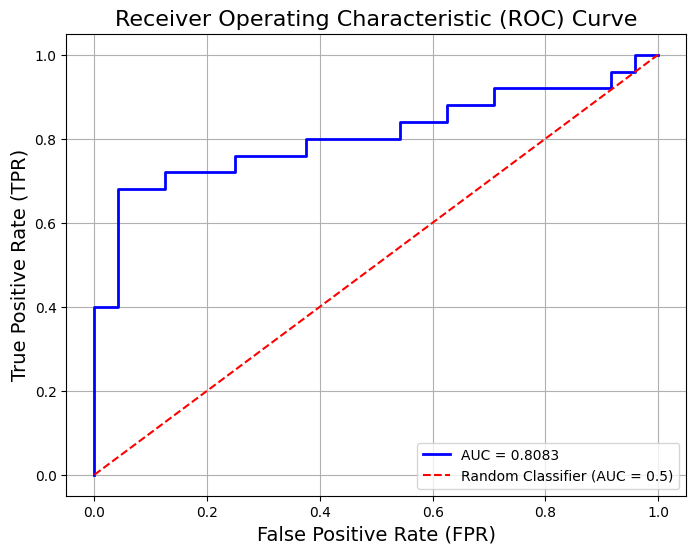

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_rf_model.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 354 out of 354 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 conc

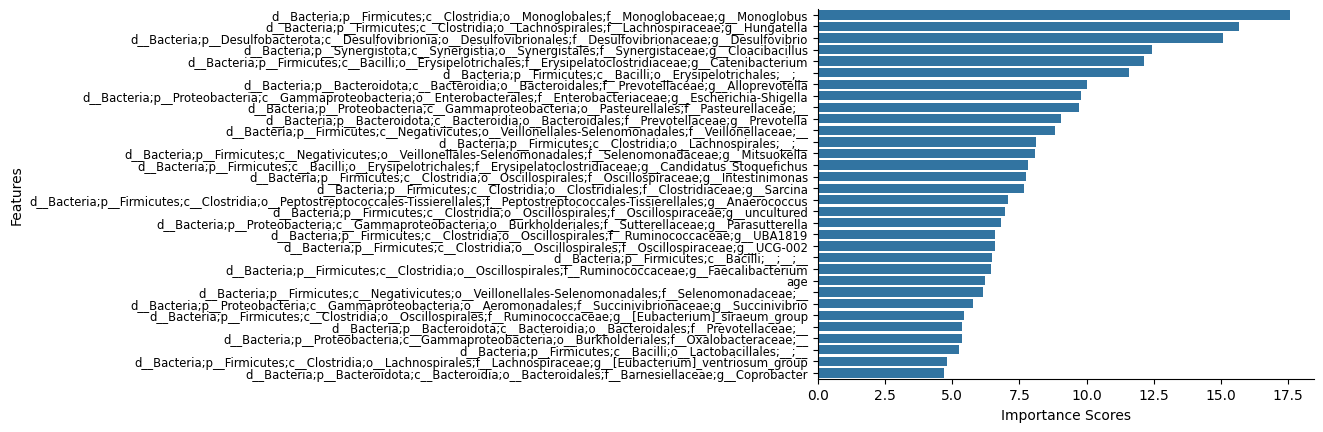

Number of features selected: 32
Markov Blanket: ['d__Bacteria;p__Firmicutes;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__Monoglobus', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Hungatella', 'd__Bacteria;p__Desulfobacterota;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio', 'd__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;__;__', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella', 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;__', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroid

In [6]:
from sklearn.linear_model import LogisticRegression

# Initialize the LogisticRegression
clf = LogisticRegression(random_state=42)

# Initialize the PPIMBC model for feature selection using the random forest classifier as the base model
clf_model = PPIMBC(clf, p_val_thresh=0.01, num_simul=30, simul_size=0.2, simul_type=0, sig_test_type="non-parametric", cv=0, verbose=2, random_state=42)

# Fit the PPIMBC model on the training data and transform the train dataset to the selected feature subset
X_train_selected = clf_model.fit_transform(X_train, y_train)

# Transform the test dataset with the selected features
X_test_selected = clf_model.transform(X_test)

# Plot the feature importance scores
clf_model.feature_importance()

# Get the column names of the selected features
selected_features = clf_model.MB

# Check if 'age' is one of the selected features, if not add it
if 'age' not in selected_features:
    print(f"'age' not in selected features, adding 'age'.")
    selected_features.append('age')

print("Number of features selected:", len(selected_features))
print("Markov Blanket:", selected_features)
print("Feature importance Scores:", clf_model.feat_imp_scores)

# Create a new DataFrame with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train LogisticRegression on the selected features
final_clf_model = LogisticRegression(random_state=42)
final_clf_model.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred = final_clf_model.predict(X_test_selected)

# Evaluate the model performance
clf_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy using selected PPIMBC features: {clf_accuracy:.4f}")

In [9]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(final_clf_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores (5-fold): {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")


Cross-validation accuracy scores (5-fold): [0.82608696 0.95652174 0.81818182 0.68181818 0.77272727]
Mean cross-validation accuracy: 0.8111


In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        24
           1       0.82      0.72      0.77        25

    accuracy                           0.78        49
   macro avg       0.78      0.78      0.78        49
weighted avg       0.78      0.78      0.77        49


Confusion Matrix:
[[20  4]
 [ 7 18]]



AUC-ROC Score: 0.8050


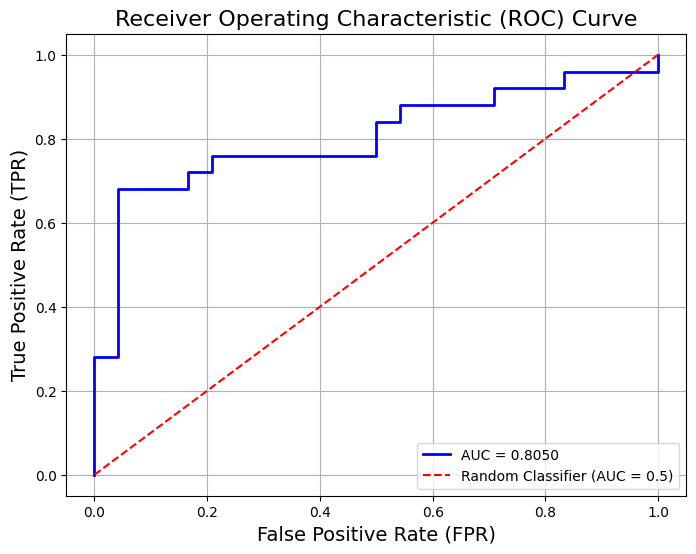

In [11]:
# Calculate Probabilities for the positive class
y_pred_prob = final_clf_model.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [12]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for LogisticRegression using RandomizedSearchCV
clf_param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}
clf_random_search = RandomizedSearchCV(estimator=final_clf_model, param_distributions=clf_param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the selected feature subset
clf_random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters for LogisticRegression
best_clf_params = clf_random_search.best_params_
print(f"Best LogisticRegression hyperparameters: {best_clf_params}")

# Get the best LogisticRegression model
best_clf_model = clf_random_search.best_estimator_

# Train LogisticRegression on the selected features with the best hyperparameters
best_clf_model.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred = best_clf_model.predict(X_test_selected)

# Evaluate the model performance
best_clf_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy using selected PPIMBC features and tuned Logistic Regression: {best_clf_accuracy:.4f}")

# Perform 5-fold cross-validation with the best RandomForest model
clf_cv_scores = cross_val_score(best_clf_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores (5-fold): {clf_cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(clf_cv_scores):.4f}")

Best LogisticRegression hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 100}

Accuracy using selected PPIMBC features and tuned Logistic Regression: 0.6939

Cross-validation accuracy scores (5-fold): [0.82608696 0.82608696 0.63636364 0.72727273 0.68181818]
Mean cross-validation accuracy: 0.7395


In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        24
           1       0.78      0.56      0.65        25

    accuracy                           0.69        49
   macro avg       0.71      0.70      0.69        49
weighted avg       0.71      0.69      0.69        49


Confusion Matrix:
[[20  4]
 [11 14]]



AUC-ROC Score: 0.7817


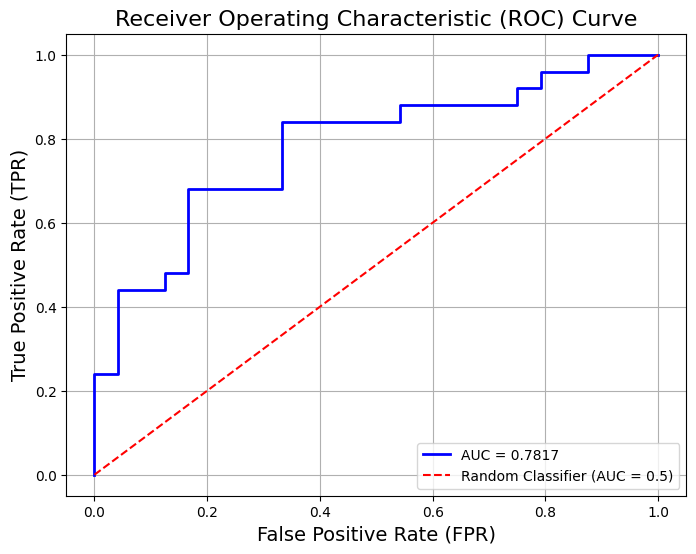

In [14]:
# Calculate Probabilities for the positive class
y_pred_prob = best_clf_model.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

**SMOTE Technique With RandomForestclassifier**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define the pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the pipeline using the selected features
pipeline.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_selected)
accuracy_before_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (before tuning): {accuracy_before_tuning:.4f}")

# Evaluate the model using cross-validation with different scoring metrics
cv_accuracy_before = cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (before tuning): {cv_accuracy_before}")
print(f"Mean CV Accuracy (before tuning): {cv_accuracy_before.mean():.4f}")

Test Accuracy (before tuning): 0.7551
5-Fold CV Accuracy (before tuning): [0.82608696 0.82608696 1.         0.81818182 0.77272727]
Mean CV Accuracy (before tuning): 0.8486


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        24
           1       0.84      0.64      0.73        25

    accuracy                           0.76        49
   macro avg       0.77      0.76      0.75        49
weighted avg       0.77      0.76      0.75        49


Confusion Matrix:
[[21  3]
 [ 9 16]]



AUC-ROC Score: 0.7908


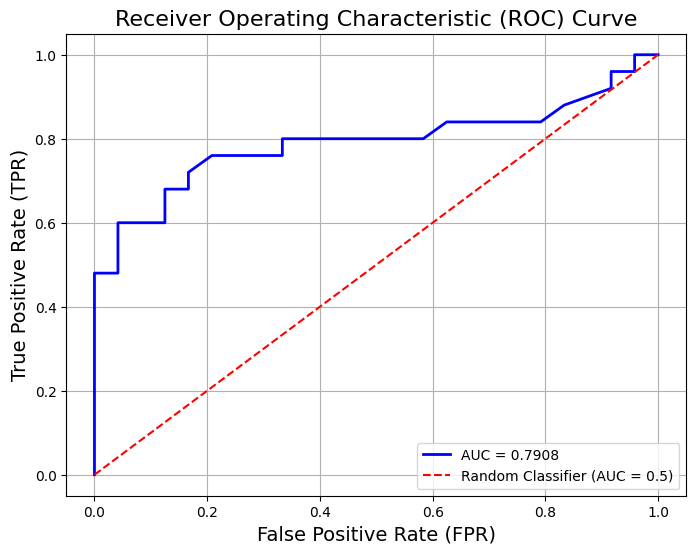

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for RandomForestclassifier using RandomizedSearchCV
param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}
rf_random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_rf_params = rf_random_search.best_params_
print(f"Best Random Forest parameters: {best_rf_params}")

# Get the best Random Forest model
best_pipeline = rf_random_search.best_estimator_

# Evaluate the best Random Forest model on the test set
y_pred = best_pipeline.predict(X_test_selected)
accuracy_after_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (after tuning): {accuracy_after_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation after tuning
cv_accuracy_after = cross_val_score(best_pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (after tuning): {cv_accuracy_after}")
print(f"Mean CV Accuracy (after tuning): {cv_accuracy_after.mean():.4f}")

Best Random Forest parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_depth': None, 'rf__bootstrap': False}
Test Accuracy (after tuning): 0.7551
5-Fold CV Accuracy (after tuning): [0.82608696 0.82608696 0.95454545 0.77272727 0.77272727]
Mean CV Accuracy (after tuning): 0.8304


In [ ]:
# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        24
           1       0.84      0.64      0.73        25

    accuracy                           0.76        49
   macro avg       0.77      0.76      0.75        49
weighted avg       0.77      0.76      0.75        49


Confusion Matrix:
[[21  3]
 [ 9 16]]



AUC-ROC Score: 0.7867


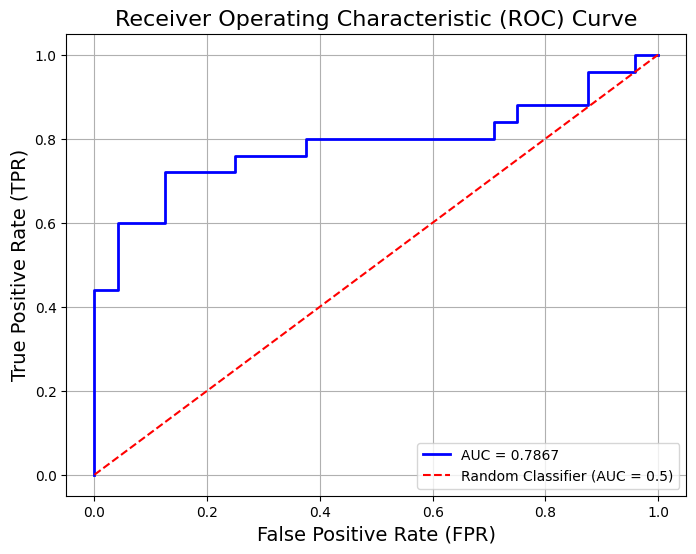

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

**SMOTE Technique With LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline with SMOTE and LogisticRegression
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42))
])

# Train the pipeline using the selected features
pipeline.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_selected)
accuracy_before_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (before tuning): {accuracy_before_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation
cv_accuracy_before = cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (before tuning): {cv_accuracy_before}")
print(f"Mean CV Accuracy (before tuning): {cv_accuracy_before.mean():.4f}")

Test Accuracy (before tuning): 0.7551
5-Fold CV Accuracy (before tuning): [0.7826087  0.82608696 0.86363636 0.72727273 0.72727273]
Mean CV Accuracy (before tuning): 0.7854


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.81      0.68      0.74        25

    accuracy                           0.76        49
   macro avg       0.76      0.76      0.75        49
weighted avg       0.76      0.76      0.75        49


Confusion Matrix:
[[20  4]
 [ 8 17]]



AUC-ROC Score: 0.8100


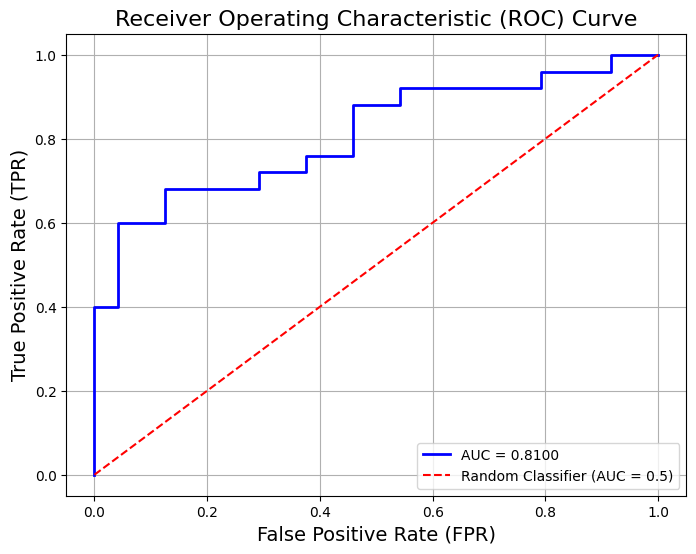

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for LogisticRegression using RandomizedSearchCV
param_dist = {
    'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty
    'clf__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'clf__max_iter': [100, 200, 300]  # Maximum number of iterations
}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f'Best hyperparameters: {best_params}')

# Train the model with the best hyperparameters
best_pipeline = random_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred = best_pipeline.predict(X_test_selected)
accuracy_after_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (after tuning): {accuracy_after_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation after tuning
cv_accuracy_after = cross_val_score(best_pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (after tuning): {cv_accuracy_after}")
print(f"Mean CV Accuracy (after tuning): {cv_accuracy_after.mean():.4f}")

Best hyperparameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__max_iter': 300, 'clf__C': 0.1}
Test Accuracy (after tuning): 0.6939
5-Fold CV Accuracy (after tuning): [0.7826087  0.73913043 0.86363636 0.72727273 0.72727273]
Mean CV Accuracy (after tuning): 0.7680


In [ ]:
# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69        24
           1       0.71      0.68      0.69        25

    accuracy                           0.69        49
   macro avg       0.69      0.69      0.69        49
weighted avg       0.69      0.69      0.69        49


Confusion Matrix:
[[17  7]
 [ 8 17]]



AUC-ROC Score: 0.8067


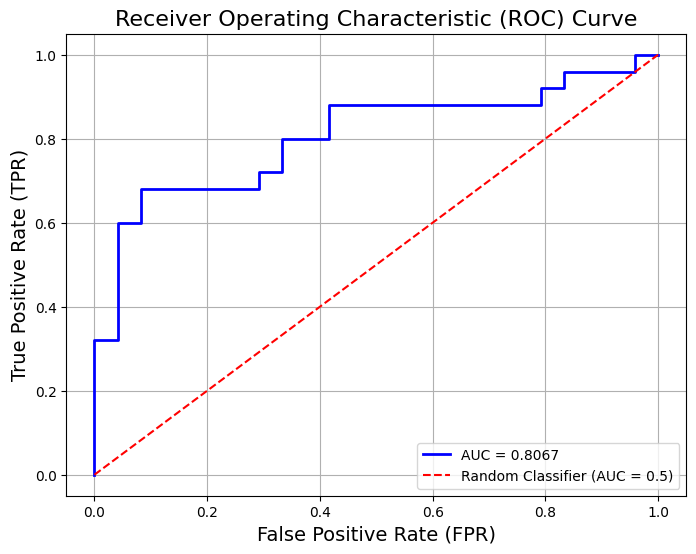

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Save final model**

In [1]:
import pickle

save_path = '/content/drive/MyDrive/FYP_Model/best_PyImpetus_random_forest_model.pkl'
with open(save_path, 'wb') as file:
    pickle.dump({
        'model': rf_model,
        'selected_features': selected_features
    }, file)

print(f"Model and selected features saved to {save_path}")

Model and selected features saved to /content/drive/MyDrive/FYP_Model/best_PyImpetus_random_forest_model.pkl


**Load the saved model**

In [ ]:
# Load the saved model
save_path = '/content/drive/MyDrive/FYP_Model/best_PyImpetus_random_forest_model.pkl'

with open(save_path, 'rb') as file:
    data = pickle.load(file)

rf_model = data['model']
selected_features = data['selected_features']
print("Model and selected features loaded successfully.")

print("Number of features selected:", len(selected_features))
print("Markov Blanket:", selected_features)

Model and selected features loaded successfully.
Number of features selected: 54
Markov Blanket: ['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella', 'd__Bacteria;p__Desulfobacterota;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium', 'age', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__Monoglobus', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Flavonifractor', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g